# Calibration Diagnostic

In [1]:
# These are the defaults for the run. They are overwritten on command-line.
observation = '/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz/'
settings = 'settings.yaml'
global_config = {}

In [2]:
# Parameters
observation = "/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz"
settings = "settings.yaml"
global_config = {}


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import edges_io as eio
import edges_cal as ec
from edges_cal.config import config
from pathlib import Path
import warnings
from beautifultable import BeautifulTable
from astropy import units as un
import numpy as np

This document shows the results of calibration for: 

In [4]:
config.update(global_config)
calobs = ec.CalibrationObservation.from_yaml(settings, obs_path=observation)
io_obs = calobs.metadata['io']

In [5]:
obspath = Path(io_obs.original_path).absolute()
print("Obs. Location       :", obspath)

print("Date Run            :", datetime.now())
print("Version of edges-io :", eio.__version__)
print("Version of edges-cal:", ec.__version__)

Obs. Location       : /data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz
Date Run            : 2022-10-04 15:13:47.185158
Version of edges-io : 4.1.4.dev4+g24ca729.d20220928
Version of edges-cal: 6.2.3.post0.dev2+g6723d3f.dirty


In [6]:
antsims = {name: calobs.new_load(load_name=name, io_obj=io_obs, unaveraged=True) for name in io_obs.simulator_names}

/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/spectra.py:239: UserWarning: Median filter did not converge
  warnings.warn("Median filter did not converge")


In [7]:
all_loads = {**calobs.loads, **antsims}

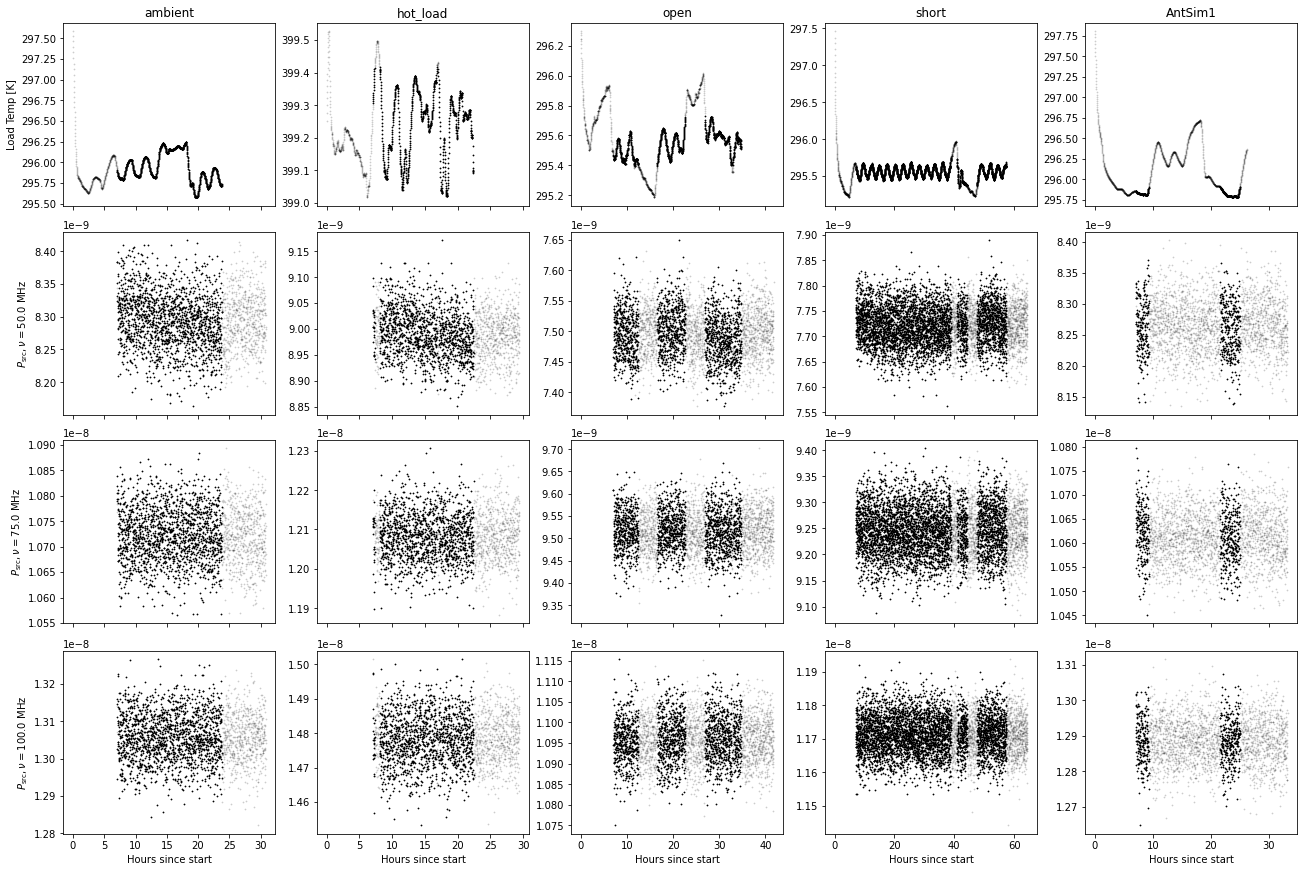

In [8]:
if 'lna_resistance' not in calobs.ambient.spectrum.thermistor.data.dtype.names:
    # this is an old observation and we only have the load measurements.

    fig, ax = plt.subplots(4, len(all_loads), figsize=(18, 12), sharex='col', gridspec_kw={'hspace': 0.05}, constrained_layout=True)

    for i, (name, load) in enumerate(all_loads.items()):
        amb = load.spectrum
        
        t = amb.thermistor.get_timestamps(with_mask=False)
        tt = np.array([(tt - t[0]).total_seconds() / 3600 for tt in t])
        ttm = tt[amb.thermistor.mask]
        
        ax[0, i].set_title(name)
        
        ax[0, i].scatter(tt, amb.thermistor.raw_load_temperature, alpha=0.2, color='k', s=3, lw=0)
        ax[0, i].scatter(ttm, amb.thermistor.load_temperature, alpha=1, color='k', s=3, lw=0)
        if i==0:
            ax[0, i].set_ylabel("Load Temp [K]")

        ax[-1, i].set_xlabel("Hours since start")

        tspec = ec.spectra.get_spec_timestamps(getattr(io_obs.spectra, name), 0)[0]
        tt = np.array([(tt - t[0]).total_seconds() / 3600 for tt in tspec])

        ttm = tt[~amb.flags[0]]
        ax[1, i].scatter(tt, amb.p_ant[0], alpha=0.2, color='k', s=3, lw=0)
        ax[1, i].scatter(ttm, amb.p_ant[0, ~amb.flags[0]], alpha=1, color='k', s=3, lw=0)
        if i==0:
            ax[1, i].set_ylabel(r"$P_{\rm src}, \nu=%.1f$ MHz"%amb.freq.freq[0].value)

        ttm = tt[~amb.flags[amb.freq.n//2]]
        ax[2, i].scatter(tt, amb.p_ant[amb.freq.n//2], alpha=0.2, color='k', s=3, lw=0)
        ax[2, i].scatter(ttm, amb.p_ant[amb.freq.n//2, ~amb.flags[amb.freq.n//2]], alpha=1, color='k', s=3, lw=0)
        if i==0:
            ax[2, i].set_ylabel(r"$P_{\rm src}, \nu=%.1f$ MHz"%amb.freq.freq[amb.freq.n//2].value)

        ttm = tt[~amb.flags[amb.freq.n - 1]]
        ax[3, i].scatter(tt, amb.p_ant[amb.freq.n - 1], alpha=0.2, color='k', s=3, lw=0)
        ax[3, i].scatter(ttm, amb.p_ant[amb.freq.n - 1, ~amb.flags[amb.freq.n - 1]], alpha=1, color='k', s=3, lw=0)
        if i==0:
            ax[3, i].set_ylabel(r"$P_{\rm src}, \nu=%.1f$ MHz"%amb.freq.freq[amb.freq.n - 1].value)
    


**Figure 1 |** The time-evolution of the measurements. Dim points represent those that are flagged, while dark points are unflagged.

In [9]:
def plot_waterfalls(name):
    amb = all_loads[name].spectrum
    
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15, 12), gridspec_kw={"hspace":0.1, 'wspace':0.1}, constrained_layout=True)

    extent=(amb.freq.freq[0].value, amb.freq.freq[-1].value, 0, amb.q.shape[1]-1)

    mask = np.ma.masked_where(~amb.flags.T, (amb.flags.T).astype(int))

    im = ax[0,0].imshow(amb.q.T, aspect='auto', extent=extent, origin='lower')
    ax[0,0].imshow(mask, aspect='auto', extent=extent, origin='lower', alpha=0.2, cmap='gray')
    plt.colorbar(im, ax=ax[0,0])
    ax[0,0].set_title("Q Ratio")

    im = ax[0,1].imshow(amb.p_ant.T, aspect='auto', extent=extent, origin='lower')
    ax[0,1].imshow(mask, aspect='auto', extent=extent, origin='lower', alpha=0.2, cmap='gray')
    plt.colorbar(im, ax=ax[0,1])
    ax[0,1].set_title(r"$P_{\rm ant}$")

    im = ax[1,0].imshow(amb.p_load.T, aspect='auto', extent=extent, origin='lower')
    ax[1,0].imshow(mask, aspect='auto', extent=extent, origin='lower', alpha=0.2, cmap='gray')
    plt.colorbar(im, ax=ax[1,0])
    ax[1,0].set_title(r"$P_{\rm L}$")

    im = ax[1,1].imshow(amb.p_ns.T, aspect='auto', extent=extent, origin='lower')
    ax[1,1].imshow(mask, aspect='auto', extent=extent, origin='lower', alpha=0.2, cmap='gray')
    plt.colorbar(im, ax=ax[1,1])
    ax[1,1].set_title(r"$P_{\rm LNS}$");

    fig.supxlabel("Freq [MHz]")
    fig.supylabel("Time (No. Integrations)")
    fig.suptitle(name)
#plt.colorbar()

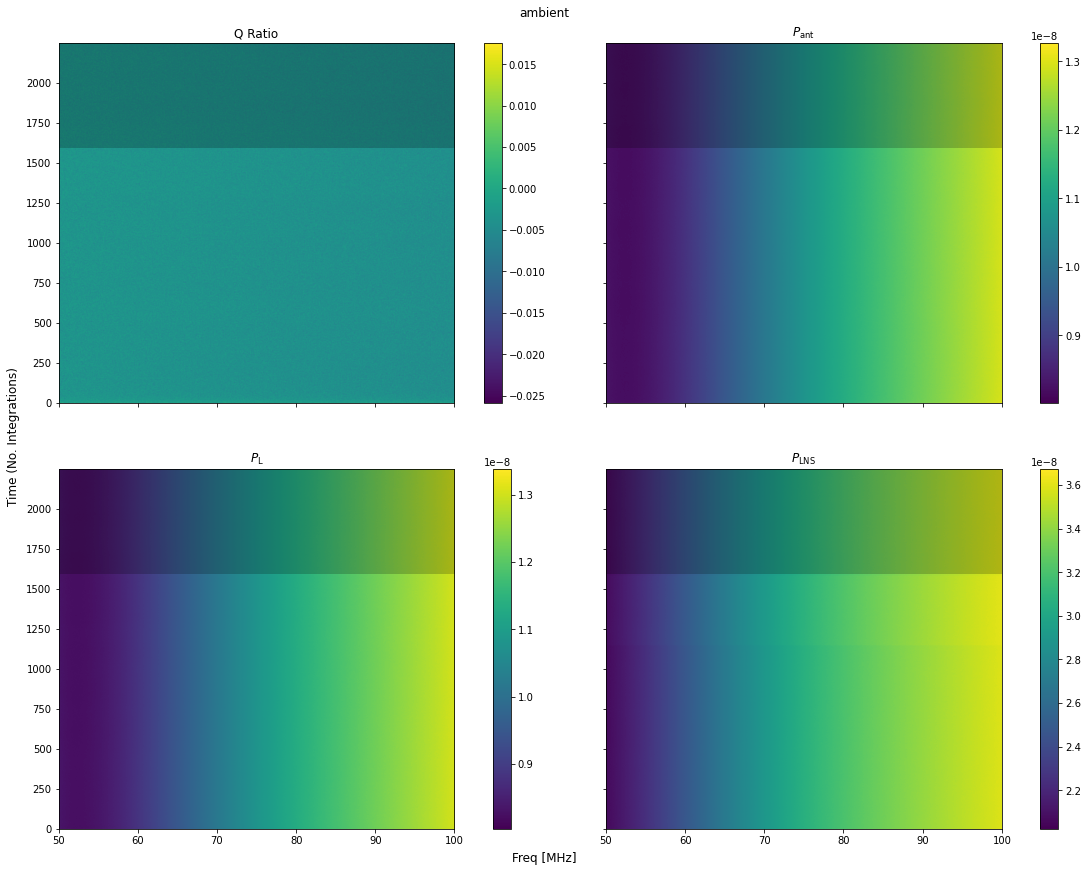

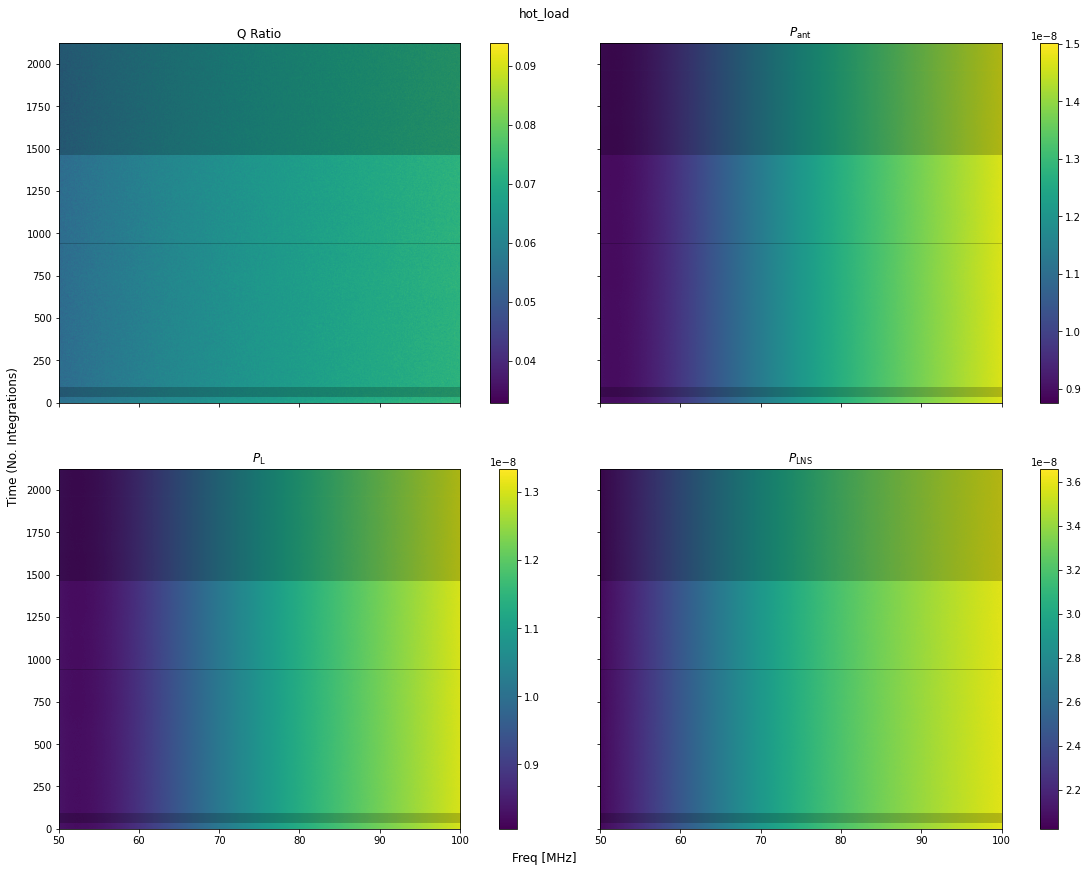

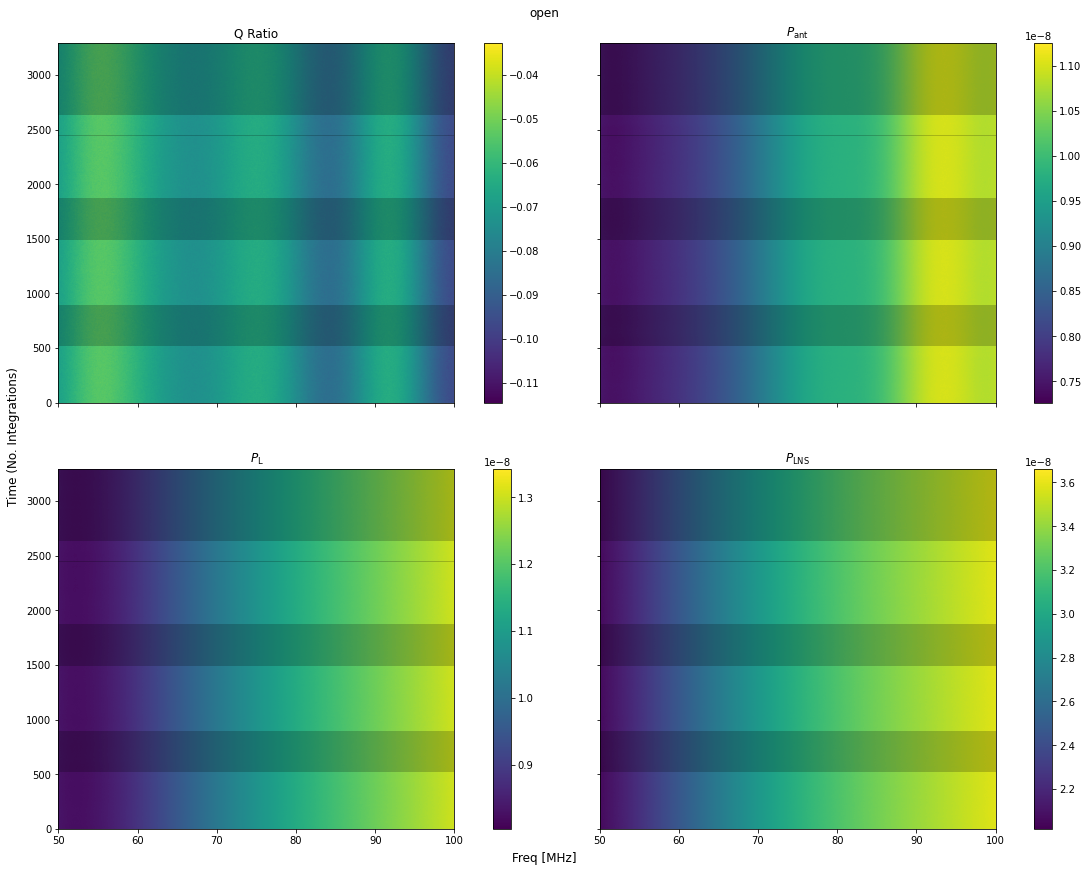

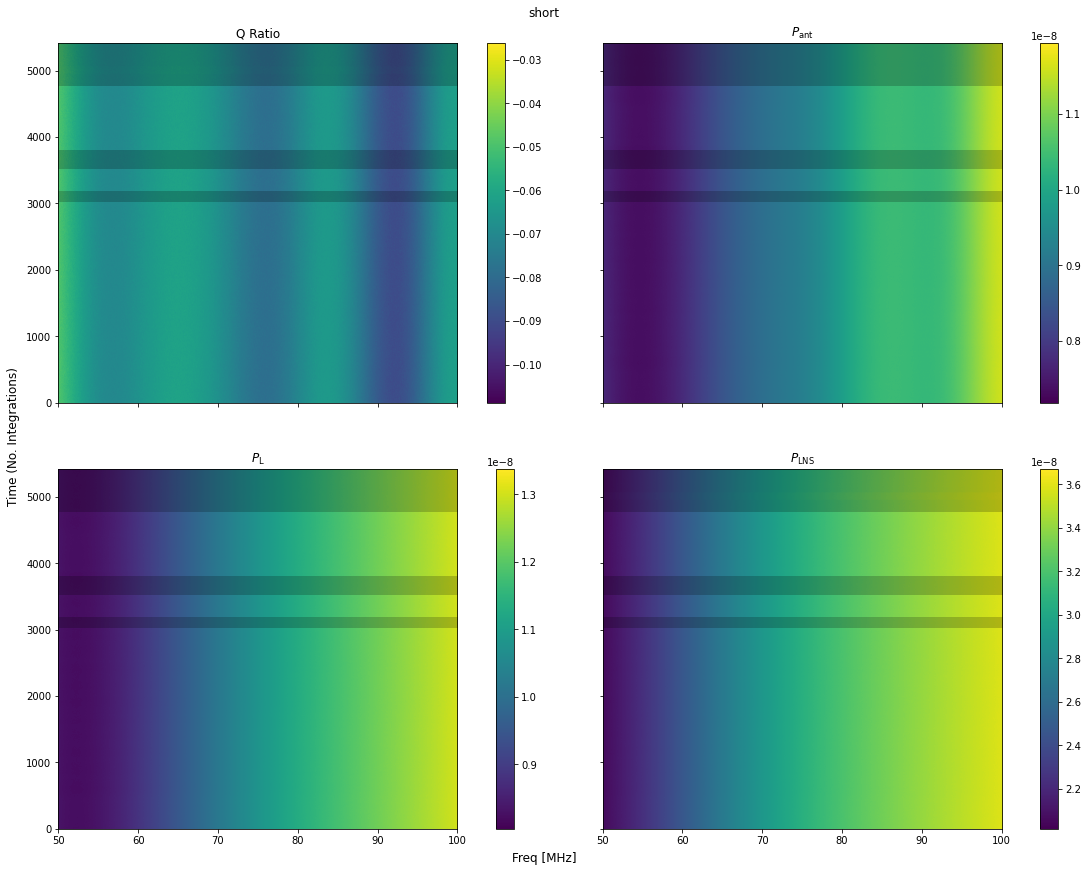

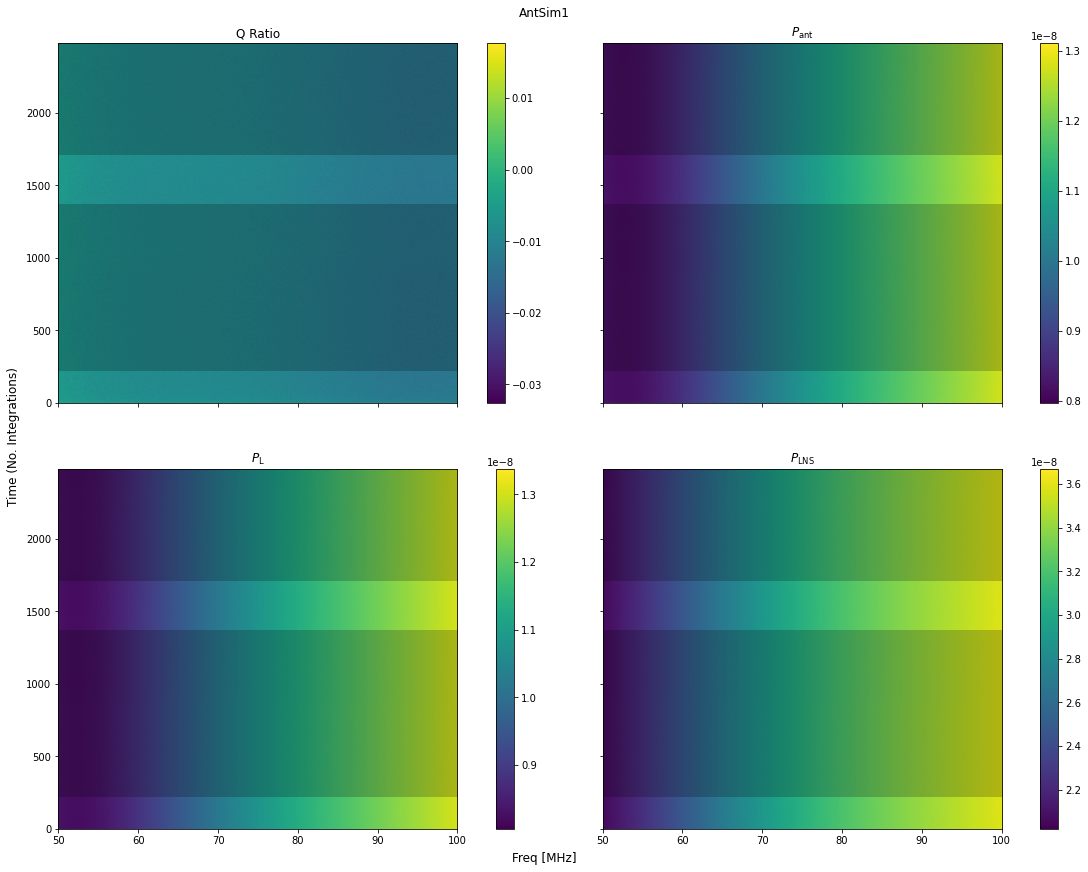

In [10]:
for name in all_loads:
    plot_waterfalls(name);

**Figure 2 |** Waterfalls for each load in the measurement. Gray overlays represent flag

## Observation Metadata

The following metadata fully defines this calibration for this version of `edges-cal`:

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame(
    [[
        calobs.wterms, 
        calobs.cterms, 
        calobs.freq.min, 
        calobs.freq.max, 
        calobs.receiver.metadata['calkit'].match.resistance, 
        calobs.internal_switch.metadata['calkit'].match.resistance,
        calobs.receiver.n_terms
    ]], 
    columns=[
        "wterms", 
        "cterms", 
        "f_min", 
        "f_max", 
        "Ext. Calkit (rcv) Match Res.", 
        "Int. Calkit Match Res.", 
        "Receiver S11 nterms"
    ]
)

df.style.set_table_attributes("style='display:inline'").set_caption('General Parameters used in the Calibration').hide_index()

wterms,cterms,f_min,f_max,Ext. Calkit (rcv) Match Res.,Int. Calkit Match Res.,Receiver S11 nterms
12,10,50.0 MHz,100.0 MHz,49.98 Ohm,50.12 Ohm,37


In [13]:
columns = [
    'S11 Run', 
    'S11 Rep.', 
    'S11 nterms',
    'Spec/Res. Run', 
] + list(all_loads['ambient'].spectrum.metadata.keys())

sources = []
table = []
for name, source in all_loads.items():
    sources.append(name)

    table.append(
        [
            io_obs.s11.run_num[name],
            io_obs.s11.repeat_num[name],
            source.reflections.n_terms,
            getattr(io_obs.spectra, name)[0].run_num,
        ] + list(source.spectrum.metadata.values())
    )


df = pd.DataFrame(np.array(table, dtype=object).T, columns=sources, index=columns)

df = df.drop('spectra_path').drop('resistance_path')

df.style.set_table_attributes("style='display:inline'").set_caption('Parameters Used For Each Load')
#df.style.format({'rfi_threshold': '{:.2f}', 'temperature_range': '{:.2f}', 'temperature_median_filter': '{:.2f}'})


,ambient,hot_load,open,short,AntSim1
S11 Run,[1],[1],[1],[1],[1]
S11 Rep.,[1],[1],[1],[1],[1]
S11 nterms,37,37,105,105,55
Spec/Res. Run,01,01,01,01,01
freq_bin_size,1,1,1,1,1
spectrum_warmup_time,0.0 s,0.0 s,0.0 s,0.0 s,0.0 s
rfi_threshold,6.000000,6.000000,6.000000,6.000000,6.000000
rfi_kernel_width_freq,16,16,16,16,16
temperature_range,1.500000,1.500000,1.500000,1.500000,1.500000
frequency_smoothing,bin,bin,bin,bin,bin


In [14]:
print("Antenna Simulators Available:", ', '.join(sorted(io_obs.simulator_names)))

Antenna Simulators Available: AntSim1


## Spectrum Data

/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/spectra.py:775: RuntimeWarning: invalid value encountered in true_divide
  return np.where(weights>0, sm / weights, np.nan)


/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/spectra.py:775: RuntimeWarning: invalid value encountered in true_divide
  return np.where(weights>0, sm / weights, np.nan)


/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/tools.py:402: RuntimeWarning: Mean of empty slice
  return np.nanmean(x[..., :nn].reshape(x.shape[:-1] + (-1, size)), axis=-1)
/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/tools.py:402: RuntimeWarning: Mean of empty slice
  return np.nanmean(x[..., :nn].reshape(x.shape[:-1] + (-1, size)), axis=-1)
/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/tools.py:402: RuntimeWarning: Mean of empty slice
  return np.nanmean(x[..., :nn].reshape(x.shape[:-1] + (-1, size)), axis=-1)
/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/tools.py:402: RuntimeWarning: Mean of empty slice
  return np.nanmean(x[..., :nn].reshape(x.shape[:-1] + (-1, size)), axis=-1)
/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/spectra.py:775: RuntimeWarning: invalid value encountered in true_divide
  return np.where(weights>0, sm / weights, np.nan)


/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/tools.py:402: RuntimeWarning: Mean of empty slice
  return np.nanmean(x[..., :nn].reshape(x.shape[:-1] + (-1, size)), axis=-1)


Text(0, 0.5, 'Calibrated Temp (K)')

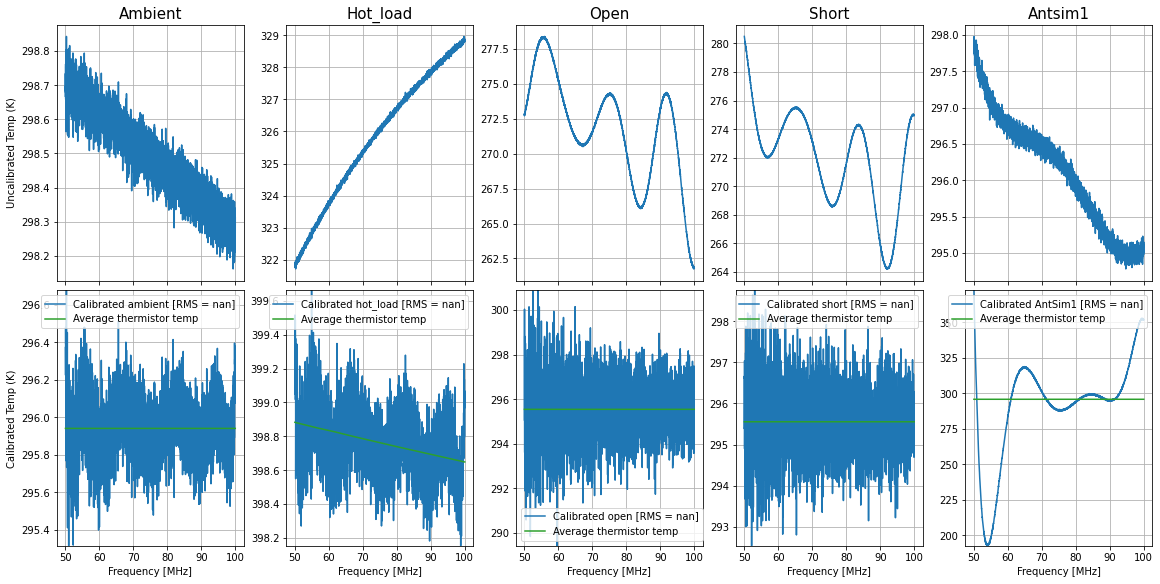

In [15]:
fig, ax = plt.subplots(
    2,len(all_loads),figsize=(16,8), sharex=True, constrained_layout=True
)

for i, (name, load) in enumerate(all_loads.items()):
    ax[0,i].set_title(name.capitalize(), fontsize=15)
    ec.plot.plot_raw_spectrum(load.spectrum, fig=fig, ax=ax[0,i], ylabel=False, xlabel=False)
    calobs.plot_calibrated_temp(load, ax=ax[1,i],ylabel=False)
    
ax[0,0].set_ylabel("Uncalibrated Temp (K)")
ax[1,0].set_ylabel("Calibrated Temp (K)")

**Figure 1 | Spectrum Measurements.** Each column is a known input calibrator source. Top row is the measured thermistor temperature in K as a function of time (in number of integrations). Second row is the *uncalibrated* measured temperature of the spectrum, as a function of frequency. The third row is the *calibrated* temperature (see figure 5 for the calibration coefficients) shown against the average thermistor temperature across the band.

**Figure 2 | Antenna Simulator Spectra.** This plot shows the same measurements as Figure 1, but for the antenna simulators measured in this calibration.

## S11

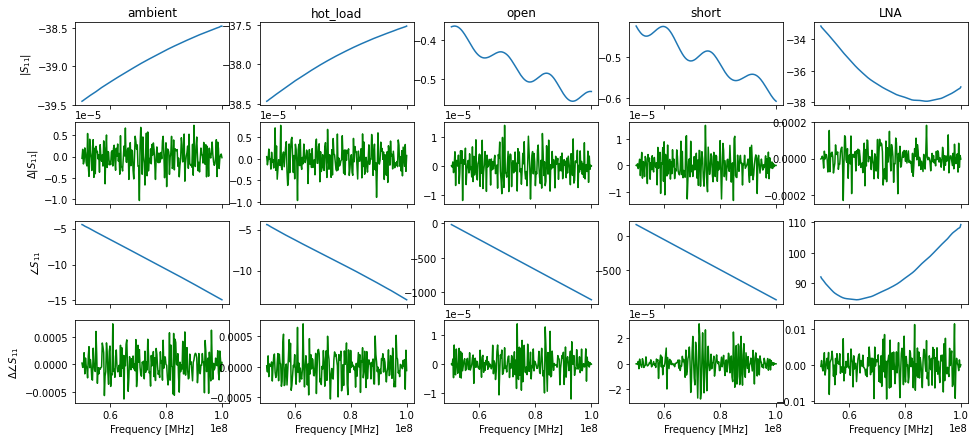

In [16]:
fig, ax = plt.subplots(4,5, sharex=True, figsize=(16, 7))
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(calobs.loads.items()):
    source.reflections.plot_residuals(fig=fig, ax=ax[:,i], title=False, decade_ticks=False,ylabels=not i)
    ax[0,i].set_title(name)
    
calobs.receiver.plot_residuals(fig=fig, ax=ax[:,-1], title=False, decade_ticks=False,ylabels=False)
ax[0,-1].set_title("LNA");

**Figure 3 | Reflection Measurements.** This shows the reflection coefficient, $S_{11}$, for each input calibrator (columns). Top row shows the measured magnitude, second row the error in the model of the magnitude, the third row shows the phase angle and the bottom row shows the error in the magnitude of the phase. 

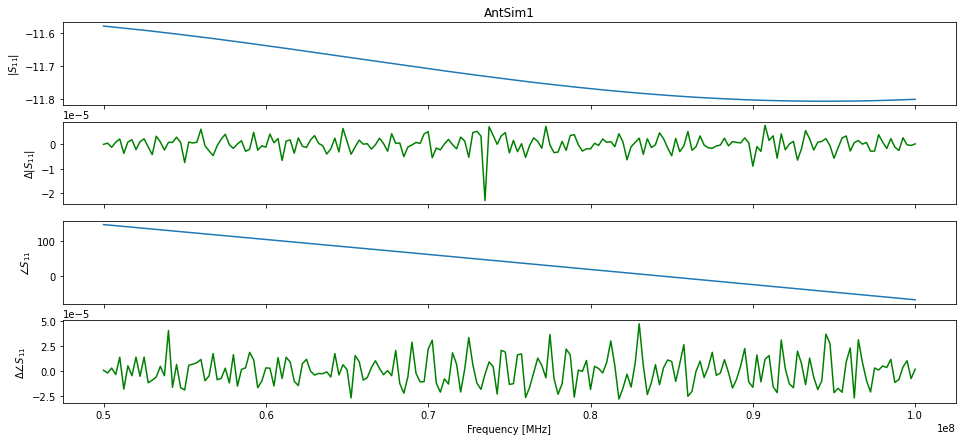

In [17]:
fig, ax = plt.subplots(4,len(antsims), sharex=True, figsize=(16, 7), squeeze=False)
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i, (name, source) in enumerate(antsims.items()):
    source.reflections.plot_residuals(fig=fig, ax=ax[:,i], title=False, decade_ticks=False,ylabels=not i)
    ax[0,i].set_title(name)

**Figure 4 | Antenna Simulator Reflection Coefficients.** The same as Fig. 3, but for the antenna simulators measured for this calibration observation.

## Calibration

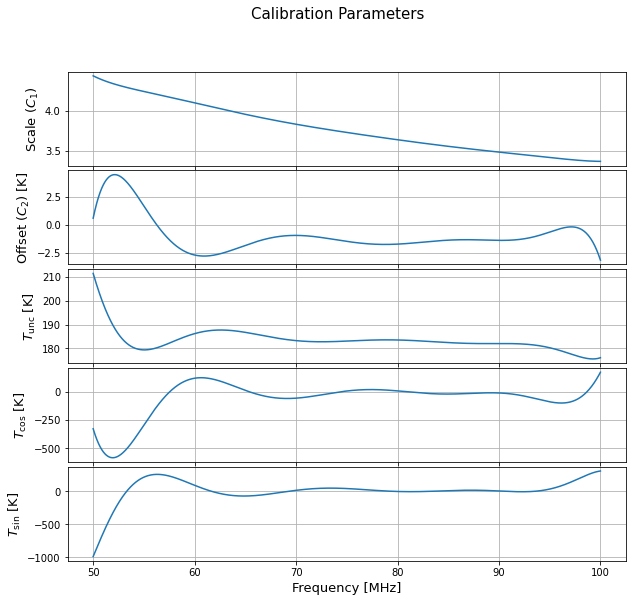

In [18]:
calobs.plot_coefficients();

**Figure 5 | Calibration Coefficients.** This shows the calibration coefficients as a function of frequency, as measured by optimizing the RMS of the calibrated temperatures of the input calibrator sources. The top row shows the overall scaling of the temperature required, the second row shows the overall offset, and the third, fourth and fifth rows show the noise-wave parameters (uncorrelated, cosine and sine).

## All Files Used

In [19]:
import os
def list_files(startpath, filter_list):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(str(startpath), '').count(os.sep)
        indent = ' ' * 4 * (level)
        ff = [f for f in files if any(str(x).startswith(str(Path(root)/f)) for x in filter_list)]
        dd = [d for d in dirs if any(str(x).startswith(str(Path(root)/d)) for x in filter_list)]
        if ff or dd:
            print('{}{}/'.format(indent, os.path.basename(root)))
        if ff:
            subindent = ' ' * 4 * (level + 1)
            for f in ff:
                print('{}{}'.format(subindent, f))

In [20]:
fl = io_obs.list_of_files[0]
list_files(obspath.parent, io_obs.list_of_files)

Receiver01/


    Receiver01_25C_2015_09_02_040_to_200MHz/
        S11/
            SwitchingState01/
                Short01.s1p
                ExternalShort01.s1p
                ExternalOpen01.s1p
                Open01.s1p
                ExternalMatch01.s1p
                Match01.s1p
            ReceiverReading08/
                Short01.s1p
                Open01.s1p
                Match01.s1p
                ReceiverReading01.s1p
            LongCableOpen01/
                Short01.s1p
                External01.s1p
                Open01.s1p
                Match01.s1p
            HotLoad01/
                Short01.s1p
                External01.s1p
                Open01.s1p
                Match01.s1p
            Ambient01/
                Short01.s1p
                External01.s1p
                Open01.s1p
                Match01.s1p
            LongCableShorted01/
                Short01.s1p
                External01.s1p
                Open01.s1p
                Match01.s1p
       